### RAG Agéntico
🤖 ¿Qué es RAG Agéntico?

RAG Agéntico significa Retrieval-Augmented Generation Agéntico (Generación Aumentada por Recuperación Agéntica) — una versión avanzada de RAG donde en lugar de una respuesta estática de un solo paso del LLM, el sistema utiliza un agente que:

- **razona** sobre el problema,
- **planifica** los pasos a seguir,
- **recupera** información relevante,
- **usa herramientas** externas,
- e incluso **reintenta o reflexiona**

para generar respuestas mejores y más fundamentadas.

In [1]:
# Importamos os para acceder a variables de entorno del sistema
import os

# Importamos List y Annotated de typing para anotaciones de tipos
# List: para definir listas tipadas
# Annotated: para agregar metadatos a los tipos
from typing import List, Annotated

# Importamos BaseModel de Pydantic para crear modelos de datos con validación
from pydantic import BaseModel

# Importamos FAISS, una biblioteca de búsqueda de similitud vectorial eficiente de Facebook
from langchain_community.vectorstores import FAISS

# Importamos WebBaseLoader para cargar documentos desde URLs
from langchain_community.document_loaders import WebBaseLoader

# Importamos RecursiveCharacterTextSplitter para dividir documentos en chunks
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Importamos init_chat_model para inicializar modelos de chat de forma genérica
from langchain.chat_models import init_chat_model

# Importamos OpenAIEmbeddings para generar embeddings vectoriales con modelos de OpenAI
from langchain_openai import OpenAIEmbeddings

# Importamos Document, la clase base para representar documentos en LangChain
from langchain.schema import Document

# Importamos StateGraph y END de LangGraph para construir grafos de estado
# StateGraph: permite crear grafos basados en estados
# END: nodo especial que marca el final del grafo
from langgraph.graph import StateGraph, END

USER_AGENT environment variable not set, consider setting it to identify your requests.
c:\Udemy\RAGBootcamp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Importamos os para gestionar variables de entorno
import os

# Importamos load_dotenv para cargar variables de entorno desde archivo .env
from dotenv import load_dotenv

# Cargamos las variables de entorno del archivo .env al sistema
load_dotenv()

# Configuramos la clave API de OpenAI desde las variables de entorno
# Esto permite autenticar las solicitudes a la API de OpenAI
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# Inicializamos el modelo de lenguaje GPT-4o de OpenAI
# init_chat_model es una función genérica que soporta múltiples proveedores
# El formato "openai:gpt-4o" especifica el proveedor y el modelo
llm = init_chat_model("openai:gpt-4o")

# Mostramos el objeto LLM para verificar su configuración
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001F25D8091F0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001F25DDE4890>, root_client=<openai.OpenAI object at 0x000001F25D828B00>, root_async_client=<openai.AsyncOpenAI object at 0x000001F25DA40CE0>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [3]:
# -----------------------------
# 1. Preprocesamiento de Documentos
# -----------------------------

# Definimos una lista de URLs de artículos de blog técnicos que servirán como base de conocimiento
# Estos artículos contienen información sobre agentes autónomos y modelos de difusión
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",  # Artículo sobre agentes potenciados por LLM
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"  # Artículo sobre modelos de difusión para video
]

# Creamos una lista de loaders (cargadores), uno por cada URL
# WebBaseLoader extrae el contenido HTML y lo convierte en documentos de LangChain
loaders = [WebBaseLoader(url) for url in urls]

# Inicializamos una lista vacía para almacenar todos los documentos cargados
docs = []

# Iteramos sobre cada loader para cargar y procesar los documentos
for loader in loaders:
    # loader.load() descarga el contenido de la URL y lo convierte en objetos Document
    # extend() agrega todos los documentos de este loader a nuestra lista principal
    docs.extend(loader.load())

# Mostramos los documentos cargados para inspeccionar su contenido y metadatos
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [4]:
## Divisor de texto recursivo por caracteres y almacén vectorial

# Inicializamos el divisor de texto recursivo con parámetros específicos
# - chunk_size=500: cada fragmento (chunk) tendrá un máximo de 500 caracteres
# - chunk_overlap=50: habrá una superposición de 50 caracteres entre chunks consecutivos
#   (esto ayuda a mantener el contexto entre fragmentos)
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

# Dividimos todos los documentos cargados en fragmentos más pequeños
# split_documents() procesa cada documento y lo divide según el tamaño especificado
# Esto es crucial para RAG porque permite búsquedas más precisas y específicas
split_docs = splitter.split_documents(docs)

# Inicializamos el modelo de embeddings de OpenAI
# Este modelo convierte texto en vectores numéricos (embeddings) de alta dimensión
embedding = OpenAIEmbeddings()

# Creamos un almacén vectorial FAISS a partir de los documentos divididos
# FAISS indexa los embeddings para permitir búsquedas de similitud rápidas
# from_documents() automáticamente:
#   1. Genera embeddings para cada documento usando el modelo especificado
#   2. Crea el índice FAISS con esos embeddings
#   3. Almacena los documentos originales junto con sus embeddings
vectorstore = FAISS.from_documents(split_docs, embedding)

# Convertimos el vectorstore en un retriever (recuperador)
# El retriever proporciona una interfaz simplificada para realizar búsquedas de similitud
# Por defecto, recuperará los k documentos más similares a una consulta dada
retriever = vectorstore.as_retriever()

In [7]:
# Probamos el retriever con una consulta de ejemplo sobre agentes
# invoke() ejecuta una búsqueda de similitud semántica en el vectorstore
# La consulta "What are agents" se convierte en un embedding y se compara con todos los documentos
# Retorna los k documentos más similares (por defecto k=4)
retriever.invoke("What are agents")

[Document(id='d4761571-626b-4698-a264-cf79e235360d', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [9]:
# -----------------------------
# 2. Definir el Estado de RAG
# -----------------------------

# Definimos una clase RAGState usando Pydantic BaseModel
# Esta clase representa el estado del grafo en nuestro sistema RAG Agéntico
# Pydantic proporciona validación automática de tipos y conversión de datos
class RAGState(BaseModel):
    # question: almacena la pregunta del usuario (requerido, tipo string)
    question: str
    
    # retrieved_docs: lista de documentos recuperados del vectorstore
    # Se inicializa como lista vacía por defecto
    # Contendrá los documentos más relevantes después de la recuperación
    retrieved_docs: List[Document] = []
    
    # answer: almacena la respuesta final generada por el LLM
    # Se inicializa como string vacío por defecto
    # Se llenará después de que el LLM procese la pregunta y el contexto
    answer: str = ""

In [10]:
# -----------------------------
# 3. Nodos de LangGraph
# -----------------------------

# Definimos el nodo "retrieve_docs" (recuperar documentos)
# Este nodo es responsable de buscar documentos relevantes en el vectorstore
def retrieve_docs(state: RAGState) -> RAGState:
    # Usamos el retriever para buscar documentos similares a la pregunta
    # invoke() realiza la búsqueda de similitud y retorna los documentos más relevantes
    docs = retriever.invoke(state.question)
    
    # Retornamos un nuevo estado actualizado con los documentos recuperados
    # Mantenemos la pregunta original y agregamos los documentos encontrados
    return RAGState(question=state.question, retrieved_docs=docs)

# Definimos el nodo "generate_answer" (generar respuesta)
# Este nodo toma los documentos recuperados y genera una respuesta usando el LLM
def generate_answer(state: RAGState) -> RAGState:
    # Construimos el contexto concatenando el contenido de todos los documentos recuperados
    # "\n\n".join() une los textos con doble salto de línea para mejor legibilidad
    # Iteramos sobre cada documento y extraemos su page_content
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    
    # Construimos el prompt para el LLM
    # El prompt incluye:
    #   1. Instrucciones claras: "Responde la pregunta basándote en el contexto"
    #   2. El contexto: documentos recuperados que contienen información relevante
    #   3. La pregunta: la consulta original del usuario
    prompt = f"Answer the question based on the context.\n\nContext:\n{context}\n\nQuestion: {state.question}"
    
    # Invocamos el LLM con el prompt construido
    # El LLM procesará el contexto y generará una respuesta fundamentada
    response = llm.invoke(prompt)
    
    # Retornamos un nuevo estado con:
    #   - La pregunta original
    #   - Los documentos recuperados (para trazabilidad)
    #   - La respuesta generada (extraída del contenido de la respuesta del LLM)
    return RAGState(
        question=state.question, 
        retrieved_docs=state.retrieved_docs, 
        answer=response.content
    )

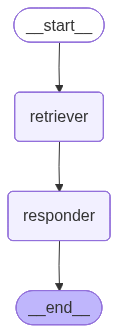

In [11]:
# -----------------------------
# 4. Construir el Grafo de LangGraph
# -----------------------------

# Inicializamos un StateGraph con nuestro esquema de estado RAGState
# StateGraph gestiona el flujo de ejecución y la propagación del estado
builder = StateGraph(RAGState)

# Agregamos el nodo "retriever" que ejecuta la función retrieve_docs
# Este nodo será responsable de buscar documentos relevantes en el vectorstore
builder.add_node("retriever", retrieve_docs)

# Agregamos el nodo "responder" que ejecuta la función generate_answer
# Este nodo tomará los documentos recuperados y generará la respuesta final
builder.add_node("responder", generate_answer)

# Definimos el punto de entrada del grafo
# set_entry_point especifica que el grafo siempre comenzará con el nodo "retriever"
# Esto significa que primero se recuperarán documentos antes de generar una respuesta
builder.set_entry_point("retriever")

# Agregamos una arista (edge) desde "retriever" a "responder"
# Esto establece un flujo lineal: recuperar documentos → generar respuesta
builder.add_edge("retriever", "responder")

# Agregamos una arista desde "responder" a END
# END es un nodo especial que indica el final del grafo
# Después de generar la respuesta, el grafo termina su ejecución
builder.add_edge("responder", END)

# Compilamos el grafo en un objeto ejecutable
# compile() valida el grafo y lo optimiza para ejecución
graph = builder.compile()

# Mostramos el grafo para visualizar su estructura
# Esto puede generar un diagrama visual del flujo de ejecución
graph

In [ ]:
# -----------------------------
# 5. Ejecutar el RAG Agéntico
# -----------------------------

# Bloque principal que se ejecuta solo si el script se ejecuta directamente
# (no cuando se importa como módulo)
if __name__ == "__main__":
    # Definimos la pregunta del usuario
    # Esta pregunta específica consulta sobre el concepto de "agent loop" en agentes autónomos
    #user_question = "What is the concept of agent loop in autonomous agents?"
    user_question = "¿Cuál es el concepto de bucle de agente en el agente autónomo?"
    # Creamos el estado inicial del grafo
    # Inicializamos RAGState con la pregunta del usuario
    # Los campos retrieved_docs y answer comenzarán vacíos (valores por defecto)
    initial_state = RAGState(question=user_question)
    
    # Ejecutamos el grafo completo con el estado inicial
    # invoke() ejecuta el grafo de principio a fin:
    #   1. Nodo "retriever": busca documentos relevantes
    #   2. Nodo "responder": genera respuesta basada en documentos
    # Retorna el estado final con todos los campos completados
    final_state = graph.invoke(initial_state)

    # Imprimimos la respuesta final generada por el sistema RAG
    # final_state es un diccionario que contiene 'question', 'retrieved_docs' y 'answer'
    # Extraemos solo el campo 'answer' que contiene la respuesta del LLM
    print("\n✅ Respuesta Final:\n", final_state['answer'])


✅ Respuesta Final:
 El concepto de bucle de agente en el agente autónomo se refiere al ciclo de acciones y reflexiones que el agente lleva a cabo para mejorar su desempeño y capacidad de razonamiento a lo largo del tiempo. Este bucle incluye el uso de la memoria dinámica, planificación y mecanismos de reflexión para aprender de experiencias pasadas, refinar decisiones de acción previas y corregir errores. En este contexto, el agente sigue un proceso iterativo de acción-reflexión, en el que después de cada acción realizada, evalúa el desempeño mediante un cálculo heurístico y, opcionalmente, puede decidir reiniciar el entorno si es necesario. Este enfoque permite a los agentes autónomos mejorar continuamente sus habilidades mediante pruebas y errores, integrando el aprendizaje a partir de experiencias anteriores para manejar tareas complejas de manera más efectiva.


In [14]:
# Mostramos el estado final completo para inspección
# final_state contiene:
#   - question: la pregunta original del usuario
#   - retrieved_docs: lista de documentos recuperados del vectorstore con sus metadatos
#   - answer: la respuesta final generada por el LLM basándose en el contexto
# Esto es útil para debugging y para entender cómo funcionó el sistema RAG
final_state

{'question': '¿Cuál es el concepto de bucle de agente en el agente autónomo?',
 'retrieved_docs': [Document(id='e52f4e8f-607e-4e23-a4c9-383a659c0c09', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criti

### 🤖 ¿Qué es ReAct?
**ReAct (Razonamiento + Acción)** es un framework donde un LLM:

- **Razona** paso a paso (por ejemplo, descompone preguntas, toma decisiones)

- **Actúa** llamando a herramientas como búsqueda, calculadoras o recuperadores

Esto lo hace perfecto para RAG Agéntico:

✅ **Pensar** → **Recuperar** → **Observar** → **Reflexionar** → **Respuesta Final**

Este paradigma permite que el agente no solo recupere información, sino que razone sobre ella y decida si necesita más información antes de responder.